# CNN

## 1. CNN의 기본 개념
Convolutional Layer (컨볼루션 레이어):

입력 이미지에 필터(또는 커널)를 적용하여 특징 맵(feature map)을 생성합니다. 필터는 이미지의 지역적 특징(에지, 텍스처 등)을 추출하는 역할을 합니다.

Pooling Layer (풀링 레이어):

컨볼루션 레이어의 출력 크기를 줄여 계산량을 줄이고, 공간적 불변성을 제공하는 역할을 합니다. 대표적으로 Max Pooling이 많이 사용됩니다.

Activation Function (활성화 함수):

ReLU 같은 함수는 비선형성을 추가해 모델이 복잡한 패턴을 학습할 수 있도록 돕습니다.

Fully Connected Layer (완전 연결 레이어):

컨볼루션과 풀링을 통해 추출한 특징을 평탄화(flatten)하여 분류 작업을 수행합니다.

## 2. 간단한 CNN 모델 구현 예제

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader as loader
import torch.nn.functional as F

In [110]:
class simple_CNN(nn.Module):
    def __init__(self):
        super(simple_CNN,self).__init__()
        self.conv1=nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1) # 첫 번째 컨볼루션 레이어: 입력 채널 1, 출력 채널 32, 커널 크기 3, 패딩 1 -> 출력: (32, 28, 28)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)# 두 번째 컨볼루션 레이어: 입력 채널 32, 출력 채널 64, 커널 크기 3, 패딩 1 -> 출력: (64, 14, 14) after pooling
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)# Max Pooling 레이어: 커널 크기 2, stride 2 -> 이미지 크기를 절반으로 줄임

        self.fc1=nn.Linear(64*7*7,128) # 풀링 후 이미지 크기: 28 -> 14 (첫 번째 pooling) -> 7 (두 번째 pooling), 채널 수 64: 총 64*7*7 features
        self.fc2=nn.Linear(128,10)

    def forward(self,x):
        x=F.relu(self.conv1(x)) # -> (batch_size, 32, 28, 28)
        x=self.pool(x)# -> (batch_size, 32, 14, 14)
        x=F.relu(self.conv2(x))# -> (batch_size, 64, 14, 14)
        x=self.pool(x)# -> (batch_size, 64, 7, 7)   -----------------------
        x=x.view(-1,64*7*7)# 평탄화: (batch_size, 64*7*7)
        x=F.relu(self.fc1(x))# -> (batch_size, 128)
        x=self.fc2(x)# -> (batch_size, 10), raw logits
        return x

In [112]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_data=datasets.MNIST(root="./data",train=True,download=True, transform=transform)
test_data=datasets.MNIST(root="./data",train=False,download=True, transform=transform)
train_loader=loader(train_data,batch_size=64, shuffle=True)
test_loader=loader(test_data, batch_size=1000, shuffle=True)

model=simple_CNN()
criter=nn.CrossEntropyLoss()
optimy=optim.Adam(model.parameters(),lr=0.001)
num_epoch=10

def train_mode(model,train_loader,criter, optimy,num_epoch=5):
    model.train()
    for epoch in range(num_epoch):
        total_loss=0.0
        for data,target in train_loader:
            optimy.zero_grad()
            out=model(data)
            loss=criter(out,target)
            loss.backward()
            optimy.step()
            total_loss+=loss.item()
        avg_loss=total_loss/len(train_loader)
        print(f"Epoch {epoch+1}/{num_epoch}, train_loss {avg_loss: .4f}")

In [119]:
def train_mode(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

In [121]:
def eval_mode(model,test_loader):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for data,target in test_loader:
            out=model(data)
            pred=out.argmax(dim=1)
            correct+=pred.eq(target).sum().item()
            total+=data.size(0)

    accuracy=100.0*correct/total
    return accuracy

In [88]:
train_mode(model, train_loader, criter, optimy, num_epoch)
eval=eval_mode(model, test_loader)
print(f"test acc: {eval:.4f}%")

Epoch 1/10, train_loss  0.0032
Epoch 2/10, train_loss  0.0019
Epoch 3/10, train_loss  0.0043
Epoch 4/10, train_loss  0.0017
Epoch 5/10, train_loss  0.0029
Epoch 6/10, train_loss  0.0038
Epoch 7/10, train_loss  0.0026
Epoch 8/10, train_loss  0.0016
Epoch 9/10, train_loss  0.0028
Epoch 10/10, train_loss  0.0019
test acc: 98.9500%


In [67]:
#하이퍼파라미터 튜닝
import itertools

lr=[0.001,0.005,0.0001]
batch_size=[32,64,128]
result={}

for lr, bs in itertools.product(lr,batch_size):
    print(f"train LR={lr}, batch_size={bs}")
    optimz=optim.Adam(model.parameters(),lr=lr)
    train_mode(model, train_loader, criter, optimz, num_epoch)
    acc=eval_mode(model, test_loader)
    result[(lr,bs)]=acc
    print(f"ACCURACY : {acc:.2f}%\n")


train LR=0.001, batch_size=32
Epoch 1/10, train_loss  0.0030
Epoch 2/10, train_loss  0.0034
Epoch 3/10, train_loss  0.0009
Epoch 4/10, train_loss  0.0021
Epoch 5/10, train_loss  0.0017
Epoch 6/10, train_loss  0.0032
Epoch 7/10, train_loss  0.0025
Epoch 8/10, train_loss  0.0031
Epoch 9/10, train_loss  0.0012
Epoch 10/10, train_loss  0.0039
ACCURACY : 99.24%

train LR=0.001, batch_size=64
Epoch 1/10, train_loss  0.0031
Epoch 2/10, train_loss  0.0020
Epoch 3/10, train_loss  0.0019
Epoch 4/10, train_loss  0.0021
Epoch 5/10, train_loss  0.0033
Epoch 6/10, train_loss  0.0025
Epoch 7/10, train_loss  0.0003
Epoch 8/10, train_loss  0.0024
Epoch 9/10, train_loss  0.0026
Epoch 10/10, train_loss  0.0022
ACCURACY : 99.12%

train LR=0.001, batch_size=128
Epoch 1/10, train_loss  0.0024
Epoch 2/10, train_loss  0.0010
Epoch 3/10, train_loss  0.0038
Epoch 4/10, train_loss  0.0016
Epoch 5/10, train_loss  0.0015
Epoch 6/10, train_loss  0.0014
Epoch 7/10, train_loss  0.0013
Epoch 8/10, train_loss  0.0042
E

# 튜닝법

In [96]:
#그리드
import itertools
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader as loader
import torch.optim as optim


In [129]:
# 하이퍼파라미터 후보 정의
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]

result_set={}
num_epoch=10

for lr, bs in itertools.product(learning_rates,batch_sizes):
    print(f"Training with LR={lr}, Batch Size={bs}")
    train_loader = loader(train_data, batch_size=bs, shuffle=True)
    test_loader = loader(test_data, batch_size=bs, shuffle=False)

    model=simple_CNN()
    criter=nn.CrossEntropyLoss()
    optimy=optim.Adam(model.parameters(),lr=lr)

    train_loss=train_mode(model,train_loader , criter, optimz, num_epoch)
    test_acc=eval_mode(model, test_loader)

    result_set[(lr,bs)]=test_acc
    print(f"Test Accuracy: {test_acc:.2f}%\n")


print("Grid Search Results:")
for (lr, bs), acc in result_set.items():
    print(f"LR: {lr}, Batch Size: {bs} -> Test Accuracy: {acc:.2f}%")

Training with LR=0.001, Batch Size=32
Epoch 1/10, Training Loss: 2.3078
Epoch 2/10, Training Loss: 2.3078
Epoch 3/10, Training Loss: 2.3078
Epoch 4/10, Training Loss: 2.3078
Epoch 5/10, Training Loss: 2.3078
Epoch 6/10, Training Loss: 2.3078
Epoch 7/10, Training Loss: 2.3078
Epoch 8/10, Training Loss: 2.3078
Epoch 9/10, Training Loss: 2.3078
Epoch 10/10, Training Loss: 2.3078
Test Accuracy: 9.56%

Training with LR=0.001, Batch Size=64
Epoch 1/10, Training Loss: 2.3013
Epoch 2/10, Training Loss: 2.3013
Epoch 3/10, Training Loss: 2.3013
Epoch 4/10, Training Loss: 2.3013
Epoch 5/10, Training Loss: 2.3013
Epoch 6/10, Training Loss: 2.3013
Epoch 7/10, Training Loss: 2.3013
Epoch 8/10, Training Loss: 2.3013
Epoch 9/10, Training Loss: 2.3013
Epoch 10/10, Training Loss: 2.3013
Test Accuracy: 15.47%

Training with LR=0.001, Batch Size=128
Epoch 1/10, Training Loss: 2.3056
Epoch 2/10, Training Loss: 2.3056
Epoch 3/10, Training Loss: 2.3055
Epoch 4/10, Training Loss: 2.3056
Epoch 5/10, Training L

In [133]:
#2. 랜덤 서치 (Random Search)
import random
# 하이퍼파라미터 후보 정의
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]

results_random={}
num_trial=5# 무작위로 5번의 조합을 실험
num_epoch=5

for i in range(num_trial):
    lr=random.choice(learning_rates)
    bs=random.choice(batch_sizes)
    print(f"Trial {i+1}: Training with LR={lr}, Batch Size={bs}")

    train_loader=loader(train_data, batch_size=bs, shuffle=True)
    test_loder=loader(test_data, batch_size=bs,shuffle=False)

    model=simple_CNN()
    criter=nn.CrossEntropyLoss()
    optimy=optim.Adam(model.parameters(),lr=lr)
    train_loss=train_mode(model,train_loader, criter, optimz, num_epoch)
    test_acc=eval_mode(model,test_loader)

    results_random[(lr,bs)]=test_acc
    print(f"Test Accuracy: {test_acc:.2f}%\n")


print("Random Search Results:")
for (lr, bs), acc in results_random.items():
    print(f"LR: {lr}, Batch Size: {bs} -> Test Accuracy: {acc:.2f}%")

Trial 1: Training with LR=0.0001, Batch Size=32
Epoch 1/5, Training Loss: 2.2998
Epoch 2/5, Training Loss: 2.2998
Epoch 3/5, Training Loss: 2.2998
Epoch 4/5, Training Loss: 2.2998
Epoch 5/5, Training Loss: 2.2998
Test Accuracy: 6.98%

Trial 2: Training with LR=0.001, Batch Size=32
Epoch 1/5, Training Loss: 2.3128
Epoch 2/5, Training Loss: 2.3128
Epoch 3/5, Training Loss: 2.3128
Epoch 4/5, Training Loss: 2.3128
Epoch 5/5, Training Loss: 2.3128
Test Accuracy: 11.29%

Trial 3: Training with LR=0.0005, Batch Size=32
Epoch 1/5, Training Loss: 2.3053
Epoch 2/5, Training Loss: 2.3053
Epoch 3/5, Training Loss: 2.3053
Epoch 4/5, Training Loss: 2.3053
Epoch 5/5, Training Loss: 2.3053
Test Accuracy: 13.16%

Trial 4: Training with LR=0.001, Batch Size=128
Epoch 1/5, Training Loss: 2.3036
Epoch 2/5, Training Loss: 2.3036
Epoch 3/5, Training Loss: 2.3036
Epoch 4/5, Training Loss: 2.3036
Epoch 5/5, Training Loss: 2.3036
Test Accuracy: 7.35%

Trial 5: Training with LR=0.001, Batch Size=64
Epoch 1/5, T

In [153]:
#베이지안 최적화 (Bayesian Optimization)
import optuna

def objective(trial):
    lr=trial.suggest_loguniform('lr', 1e-4, 1e-2)
    bs=trial.suggest_categorical('batch_size', [32, 64, 128])

    trin_loader=loader(train_data,batch_size=bs,shuffle=True)
    test_loader=loader(test_data,batch_size=bs,shuffle=True)

    
    model=simple_CNN()
    criter=nn.CrossEntropyLoss()
    optimy=optim.Adam(model.parameters(),lr=lr)

    train_mode(model,train_loader, criter, optimz, num_epoch)
    test_acc=eval_mode(model, test_loader)
    return test_acc

In [155]:
# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Accuracy: {:.2f}%".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-04-03 02:19:00,348] A new study created in memory with name: no-name-59ed04b5-b16b-4a89-98dc-f59f1d7d694f
C:\Users\JH\AppData\Local\Temp\ipykernel_16188\172203608.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr=trial.suggest_loguniform('lr', 1e-4, 1e-2)


Epoch 1/5, Training Loss: 2.3012
Epoch 2/5, Training Loss: 2.3012
Epoch 3/5, Training Loss: 2.3012
Epoch 4/5, Training Loss: 2.3013
Epoch 5/5, Training Loss: 2.3012


[I 2025-04-03 02:19:54,568] Trial 0 finished with value: 12.26 and parameters: {'lr': 0.0033601368107082194, 'batch_size': 32}. Best is trial 0 with value: 12.26.


Epoch 1/5, Training Loss: 2.3053
Epoch 2/5, Training Loss: 2.3053
Epoch 3/5, Training Loss: 2.3053
Epoch 4/5, Training Loss: 2.3053
Epoch 5/5, Training Loss: 2.3053


[I 2025-04-03 02:20:48,153] Trial 1 finished with value: 9.42 and parameters: {'lr': 0.00036731513938924017, 'batch_size': 64}. Best is trial 0 with value: 12.26.


Epoch 1/5, Training Loss: 2.3028
Epoch 2/5, Training Loss: 2.3028
Epoch 3/5, Training Loss: 2.3028
Epoch 4/5, Training Loss: 2.3028
Epoch 5/5, Training Loss: 2.3028


[I 2025-04-03 02:21:42,083] Trial 2 finished with value: 14.88 and parameters: {'lr': 0.00021486985862708487, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3017
Epoch 2/5, Training Loss: 2.3017
Epoch 3/5, Training Loss: 2.3017
Epoch 4/5, Training Loss: 2.3017
Epoch 5/5, Training Loss: 2.3017


[I 2025-04-03 02:22:36,787] Trial 3 finished with value: 11.41 and parameters: {'lr': 0.00014504668733738768, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3122
Epoch 2/5, Training Loss: 2.3122
Epoch 3/5, Training Loss: 2.3122
Epoch 4/5, Training Loss: 2.3122
Epoch 5/5, Training Loss: 2.3122


[I 2025-04-03 02:23:31,096] Trial 4 finished with value: 9.96 and parameters: {'lr': 0.0024879396705866563, 'batch_size': 128}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3089
Epoch 2/5, Training Loss: 2.3089
Epoch 3/5, Training Loss: 2.3089
Epoch 4/5, Training Loss: 2.3089
Epoch 5/5, Training Loss: 2.3089


[I 2025-04-03 02:24:25,493] Trial 5 finished with value: 5.98 and parameters: {'lr': 0.0004267316072435258, 'batch_size': 128}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3049
Epoch 2/5, Training Loss: 2.3049
Epoch 3/5, Training Loss: 2.3049
Epoch 4/5, Training Loss: 2.3049
Epoch 5/5, Training Loss: 2.3049


[I 2025-04-03 02:25:19,060] Trial 6 finished with value: 5.27 and parameters: {'lr': 0.007194778059337021, 'batch_size': 128}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3004
Epoch 2/5, Training Loss: 2.3004
Epoch 3/5, Training Loss: 2.3004
Epoch 4/5, Training Loss: 2.3004
Epoch 5/5, Training Loss: 2.3004


[I 2025-04-03 02:26:12,692] Trial 7 finished with value: 10.32 and parameters: {'lr': 0.0006083036078952965, 'batch_size': 64}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3123
Epoch 2/5, Training Loss: 2.3123
Epoch 3/5, Training Loss: 2.3123
Epoch 4/5, Training Loss: 2.3123
Epoch 5/5, Training Loss: 2.3123


[I 2025-04-03 02:27:06,848] Trial 8 finished with value: 10.38 and parameters: {'lr': 0.0006049030877862722, 'batch_size': 64}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3100
Epoch 2/5, Training Loss: 2.3100
Epoch 3/5, Training Loss: 2.3100
Epoch 4/5, Training Loss: 2.3100
Epoch 5/5, Training Loss: 2.3100


[I 2025-04-03 02:28:00,364] Trial 9 finished with value: 12.19 and parameters: {'lr': 0.0025212693896603773, 'batch_size': 64}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3043
Epoch 2/5, Training Loss: 2.3043
Epoch 3/5, Training Loss: 2.3043
Epoch 4/5, Training Loss: 2.3043
Epoch 5/5, Training Loss: 2.3043


[I 2025-04-03 02:28:53,984] Trial 10 finished with value: 12.04 and parameters: {'lr': 0.00010029420945229898, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3081
Epoch 2/5, Training Loss: 2.3081
Epoch 3/5, Training Loss: 2.3081
Epoch 4/5, Training Loss: 2.3081
Epoch 5/5, Training Loss: 2.3081


[I 2025-04-03 02:29:47,647] Trial 11 finished with value: 8.38 and parameters: {'lr': 0.002091094375176555, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3045
Epoch 2/5, Training Loss: 2.3045
Epoch 3/5, Training Loss: 2.3045
Epoch 4/5, Training Loss: 2.3046
Epoch 5/5, Training Loss: 2.3046


[I 2025-04-03 02:30:41,707] Trial 12 finished with value: 10.22 and parameters: {'lr': 0.009731835801018291, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3051
Epoch 2/5, Training Loss: 2.3051
Epoch 3/5, Training Loss: 2.3051
Epoch 4/5, Training Loss: 2.3051
Epoch 5/5, Training Loss: 2.3051


[I 2025-04-03 02:31:35,864] Trial 13 finished with value: 13.1 and parameters: {'lr': 0.0013712630216802524, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.2969
Epoch 2/5, Training Loss: 2.2969
Epoch 3/5, Training Loss: 2.2969
Epoch 4/5, Training Loss: 2.2969
Epoch 5/5, Training Loss: 2.2969


[I 2025-04-03 02:32:29,907] Trial 14 finished with value: 11.04 and parameters: {'lr': 0.00020920282353933546, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3004
Epoch 2/5, Training Loss: 2.3004
Epoch 3/5, Training Loss: 2.3004
Epoch 4/5, Training Loss: 2.3004
Epoch 5/5, Training Loss: 2.3004


[I 2025-04-03 02:33:24,050] Trial 15 finished with value: 9.65 and parameters: {'lr': 0.0012089092084547714, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3023
Epoch 2/5, Training Loss: 2.3024
Epoch 3/5, Training Loss: 2.3024
Epoch 4/5, Training Loss: 2.3024
Epoch 5/5, Training Loss: 2.3023


[I 2025-04-03 02:34:18,028] Trial 16 finished with value: 9.56 and parameters: {'lr': 0.0008983857906388913, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3066
Epoch 2/5, Training Loss: 2.3066
Epoch 3/5, Training Loss: 2.3066
Epoch 4/5, Training Loss: 2.3066
Epoch 5/5, Training Loss: 2.3066


[I 2025-04-03 02:35:11,618] Trial 17 finished with value: 7.83 and parameters: {'lr': 0.00025281042280408397, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3093
Epoch 2/5, Training Loss: 2.3092
Epoch 3/5, Training Loss: 2.3092
Epoch 4/5, Training Loss: 2.3093
Epoch 5/5, Training Loss: 2.3093


[I 2025-04-03 02:36:05,415] Trial 18 finished with value: 8.85 and parameters: {'lr': 0.001324210479553609, 'batch_size': 32}. Best is trial 2 with value: 14.88.


Epoch 1/5, Training Loss: 2.3005
Epoch 2/5, Training Loss: 2.3005
Epoch 3/5, Training Loss: 2.3006
Epoch 4/5, Training Loss: 2.3006
Epoch 5/5, Training Loss: 2.3006


[I 2025-04-03 02:36:59,072] Trial 19 finished with value: 7.28 and parameters: {'lr': 0.0048330643131978416, 'batch_size': 128}. Best is trial 2 with value: 14.88.


Best trial:
  Accuracy: 14.88%
  Params: 
    lr: 0.00021486985862708487
    batch_size: 32


In [156]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 모델 정의 (예: SimpleMNIST)
class SimpleMNIST(nn.Module):
    def __init__(self):
        super(SimpleMNIST, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)
    return 100.0 * correct / total

# 데이터 전처리 및 로딩
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 하이퍼파라미터 후보 정의
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]

results_grid = {}
num_epochs = 5

for lr, bs in itertools.product(learning_rates, batch_sizes):
    print(f"Training with LR={lr}, Batch Size={bs}")
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
    
    model = SimpleMNIST()  # 매 조합마다 모델 초기화
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
    test_acc = evaluate_model(model, test_loader)
    
    results_grid[(lr, bs)] = test_acc
    print(f"Test Accuracy: {test_acc:.2f}%\n")

# 결과 출력
print("Grid Search Results:")
for (lr, bs), acc in results_grid.items():
    print(f"LR: {lr}, Batch Size: {bs} -> Test Accuracy: {acc:.2f}%")


Training with LR=0.001, Batch Size=32
Test Accuracy: 97.37%

Training with LR=0.001, Batch Size=64
Test Accuracy: 97.69%

Training with LR=0.001, Batch Size=128
Test Accuracy: 97.69%

Training with LR=0.0005, Batch Size=32
Test Accuracy: 97.44%

Training with LR=0.0005, Batch Size=64
Test Accuracy: 97.24%

Training with LR=0.0005, Batch Size=128
Test Accuracy: 97.42%

Training with LR=0.0001, Batch Size=32
Test Accuracy: 96.39%

Training with LR=0.0001, Batch Size=64
Test Accuracy: 95.25%

Training with LR=0.0001, Batch Size=128
Test Accuracy: 94.20%

Grid Search Results:
LR: 0.001, Batch Size: 32 -> Test Accuracy: 97.37%
LR: 0.001, Batch Size: 64 -> Test Accuracy: 97.69%
LR: 0.001, Batch Size: 128 -> Test Accuracy: 97.69%
LR: 0.0005, Batch Size: 32 -> Test Accuracy: 97.44%
LR: 0.0005, Batch Size: 64 -> Test Accuracy: 97.24%
LR: 0.0005, Batch Size: 128 -> Test Accuracy: 97.42%
LR: 0.0001, Batch Size: 32 -> Test Accuracy: 96.39%
LR: 0.0001, Batch Size: 64 -> Test Accuracy: 95.25%
LR: 0.

In [168]:
설명:

itertools.product를 사용해 학습률과 배치 크기의 모든 조합을 생성합니다.

각 조합마다 모델을 초기화하고, 일정 에폭 동안 학습한 후 테스트 정확도를 평가하여 results_grid 딕셔너리에 저장합니다.



SyntaxError: invalid syntax (3930608498.py, line 1)

import random

# 하이퍼파라미터 후보 정의
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]

results_random = {}
num_trials = 5  # 무작위로 5번의 조합을 실험
num_epochs = 5

for i in range(num_trials):
    lr = random.choice(learning_rates)
    bs = random.choice(batch_sizes)
    print(f"Trial {i+1}: Training with LR={lr}, Batch Size={bs}")
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
    
    model = SimpleMNIST()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
    test_acc = evaluate_model(model, test_loader)
    
    results_random[(lr, bs)] = test_acc
    print(f"Test Accuracy: {test_acc:.2f}%\n")

# 결과 출력
print("Random Search Results:")
for (lr, bs), acc in results_random.items():
    print(f"LR: {lr}, Batch Size: {bs} -> Test Accuracy: {acc:.2f}%")


설명:

random.choice를 사용하여 학습률과 배치 크기에서 무작위로 하나씩 선택합니다.

선택된 하이퍼파라미터 조합으로 모델을 학습시키고 테스트 정확도를 평가하여 결과를 저장합니다.

In [158]:
import optuna

def objective(trial):
    # 하이퍼파라미터 제안
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    bs = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
    
    model = SimpleMNIST()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 모델 학습 (예: 5 에폭)
    train_model(model, train_loader, criterion, optimizer, num_epochs=5)
    # 모델 평가
    test_acc = evaluate_model(model, test_loader)
    return test_acc

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Accuracy: {:.2f}%".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-04-03 02:43:39,034] A new study created in memory with name: no-name-e6235949-65cc-4226-8984-0590c78eb649
C:\Users\JH\AppData\Local\Temp\ipykernel_16188\537826092.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-04-03 02:44:12,951] Trial 0 finished with value: 95.65 and parameters: {'lr': 0.005029094476405661, 'batch_size': 32}. Best is trial 0 with value: 95.65.
[I 2025-04-03 02:44:41,228] Trial 1 finished with value: 95.29 and parameters: {'lr': 0.00010237005357778991, 'batch_size': 64}. Best is trial 0 with value: 95.65.
[I 2025-04-03 02:45:15,614] Trial 2 finished with value: 97.31 and parameters: {'lr': 0.001493471888251702, 'batch_size': 32}. Best is trial 2 with value: 97.31.
[I 2025-04-03 02:45:44,240] Trial 3 finished with value: 97.84 and parameters: {

Best trial:
  Accuracy: 97.84%
  Params: 
    lr: 0.0015962293594684743
    batch_size: 64


설명:

trial.suggest_loguniform은 학습률의 범위를 로그 스케일로 탐색합니다.

trial.suggest_categorical은 배치 크기 후보에서 무작위로 하나 선택합니다.

objective 함수 내에서 제안된 하이퍼파라미터로 모델을 학습시키고, 테스트 정확도를 반환합니다.

Optuna 스터디를 생성한 후 study.optimize를 호출해 여러 번의 실험을 통해 최적의 하이퍼파라미터를 찾습니다.



저자원 GPU 환경에서는 계산 자원이 제한되기 때문에, 하이퍼파라미터 튜닝에 있어서도 효율적인 방법을 주로 사용합니다. 일반적으로 다음과 같은 방법들이 많이 활용됩니다:

랜덤 서치 (Random Search):

그리드 서치에 비해 탐색해야 하는 조합의 수를 줄이면서도 중요한 하이퍼파라미터 공간을 효과적으로 탐색할 수 있어, 계산 비용이 제한된 환경에서 유리합니다.

베이지안 최적화 (Bayesian Optimization):

Optuna, Hyperopt와 같은 라이브러리를 사용해, 이전 실험 결과를 바탕으로 최적의 하이퍼파라미터를 효율적으로 찾을 수 있습니다.

적은 실험 횟수로도 좋은 결과를 얻을 수 있어, 저자원 GPU 환경에서 많이 선호됩니다.

학습률 스케줄러와 기타 최적화 기법:

학습률 스케줄러(예: StepLR, CosineAnnealingLR 등)를 활용하여 학습 도중 학습률을 동적으로 조절하고, Mixed Precision Training이나 Gradient Accumulation과 같은 기법을 통해 GPU 자원을 효율적으로 사용하는 방법도 병행됩니다.

요약하면, 저자원 GPU 환경에서는 계산 비용을 절감하고 효율성을 극대화하기 위해 랜덤 서치나 베이지안 최적화 같은 방법이 많이 사용됩니다. Grid Search는 전체 조합을 시도해야 해서 자원이 충분치 않은 경우에는 잘 사용되지 않는 편입니다.

# 1. 모델 평가 지표 활용
1-1. 주요 평가 지표 개념
Accuracy (정확도):

전체 샘플 중에서 모델이 올바르게 예측한 비율입니다.

단순하고 직관적이지만, 클래스 불균형 문제에서는 한계가 있을 수 있습니다.

=======================================================================

Confusion Matrix (혼동 행렬):

실제 클래스와 모델의 예측 클래스 간의 관계를 행렬로 나타냅니다.

행은 실제 클래스, 열은 예측 클래스를 나타내며, 대각선의 값은 올바른 예측, 나머지는 오분류를 의미합니다.

==============================================================================

Precision (정밀도):

모델이 특정 클래스로 예측한 샘플 중 실제 해당 클래스의 비율입니다.

False Positive를 줄이는 것이 중요한 상황에서 유용합니다.

==============================================================================

Recall (재현율):

실제 특정 클래스에 속한 샘플 중 모델이 올바르게 예측한 비율입니다.

False Negative를 줄이는 것이 중요한 경우에 사용합니다.

==============================================================================

F1-score:

Precision과 Recall의 조화 평균입니다.

두 지표의 균형이 중요한 경우 사용합니다.

==============================================================================

Classification Report:

각 클래스별 Precision, Recall, F1-score, Support(실제 샘플 수)를 종합적으로 보여줍니다.

이를 통해 각 클래스별로 모델이 어떤 부분에서 약한지 진단할 수 있습니다.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader as loader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

In [7]:
class simple_CNN(nn.Module):
    def __init__(self):
        super(simple_CNN,self).__init__()
        self.conv1=nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*7*7,128)
        self.fc2=nn.Linear(128,10)

    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        x=x.view(-1, 64*7*7)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x



In [8]:
def train_mode(model, train_loader, criter, optimy, num_epoch=5):
    model.train()
    train_history = []
    for epoch in range(num_epoch):
        total_loss = 0.0
        for data, target in train_loader:
            optimy.zero_grad()
            out = model(data)
            loss = criter(out, target)
            loss.backward()
            optimy.step()
            total_loss += loss.item()  # 각 배치의 손실을 누적합니다.
        avg_loss = total_loss / len(train_loader)  # 에폭당 평균 손실 계산
        train_history.append(avg_loss)
        print(f"Epoch: {epoch+1}/{num_epoch}, Train Loss: {avg_loss:.4f}")
    return train_history


In [9]:
def eval_mode(model, test_loader):
    model.eval()
    total=0.0
    correct=0.0
    all_pred=[]
    all_target=[]
    with torch.no_grad():
        for data,target in test_loader:
            out=model(data)
            pred=out.argmax(dim=1)
            all_pred.extend(pred.cpu().numpy())
            all_target.extend(target.cpu().numpy())
            correct+=pred.eq(target).sum().item()
            total+=data.size(0)
    accuracy=100.0*correct/total
    return accuracy, np.array(all_target), np.array(all_pred)

In [14]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_data=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_data=datasets.MNIST(root='./data',train=False,download=True,transform=transform)

train_loader=loader(train_data,batch_size=64,shuffle=True)
test_loader=loader(test_data,batch_size=1000,shuffle=False)

model=simple_CNN()
criter=nn.CrossEntropyLoss()
lr=0.001
optimy=optim.Adam(model.parameters(),lr=lr)
num_epoch=10

loss_history=train_mode(model, train_loader, criter, optimy,num_epoch)
test_acc,y_true, y_pred=eval_mode(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

conf_mat=confusion_matrix(y_true,y_pred)
report=classification_report(y_true,y_pred)
print("Confusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(report)

Epoch: 1/10, Train Loss: 0.1325
Epoch: 2/10, Train Loss: 0.0417
Epoch: 3/10, Train Loss: 0.0281
Epoch: 4/10, Train Loss: 0.0216
Epoch: 5/10, Train Loss: 0.0145
Epoch: 6/10, Train Loss: 0.0119
Epoch: 7/10, Train Loss: 0.0103
Epoch: 8/10, Train Loss: 0.0086
Epoch: 9/10, Train Loss: 0.0083
Epoch: 10/10, Train Loss: 0.0055
Test Accuracy: 99.22%
Confusion Matrix:
[[ 974    1    1    0    0    0    2    2    0    0]
 [   0 1130    2    0    0    0    0    2    1    0]
 [   0    0 1025    1    0    0    0    6    0    0]
 [   0    0    0 1004    0    4    0    1    1    0]
 [   0    0    0    0  975    0    1    0    0    6]
 [   0    0    0    5    0  885    2    0    0    0]
 [   2    3    0    0    1    2  949    0    1    0]
 [   0    1    1    0    0    0    0 1025    0    1]
 [   3    0    2    1    0    0    1    0  967    0]
 [   0    0    1    1    5    4    0    5    5  988]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      

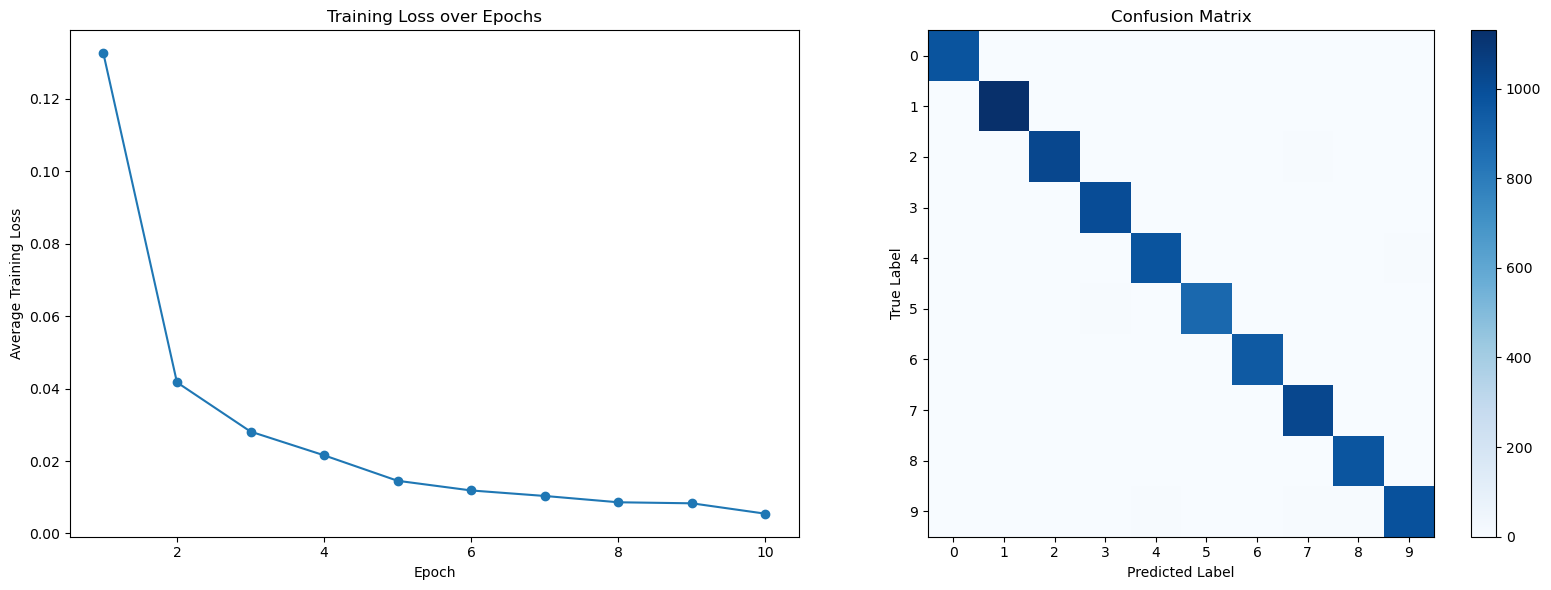

In [15]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
epoch=range(1,num_epoch+1)
plt.plot(epoch, loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss over Epochs")

plt.subplot(1,2,2)
plt.imshow(conf_mat, interpolation='nearest',cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks=np.arange(10)

plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

Epoch 1/5, Training Loss: 0.1273
Epoch 2/5, Training Loss: 0.0392
Epoch 3/5, Training Loss: 0.0267
Epoch 4/5, Training Loss: 0.0189
Epoch 5/5, Training Loss: 0.0150
Test Accuracy: 99.10%
Confusion Matrix:
[[ 973    0    0    0    0    0    3    1    2    1]
 [   0 1133    1    0    0    0    0    0    1    0]
 [   0    2 1024    0    1    0    0    4    1    0]
 [   0    0    0 1002    0    4    0    2    2    0]
 [   0    0    1    0  975    0    0    1    1    4]
 [   2    0    0    6    0  883    1    0    0    0]
 [   2    2    0    0    2    6  943    0    3    0]
 [   0    5    4    2    0    0    0 1014    1    2]
 [   2    0    1    1    0    0    0    0  966    4]
 [   0    0    0    0    3    3    0    5    1  997]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99

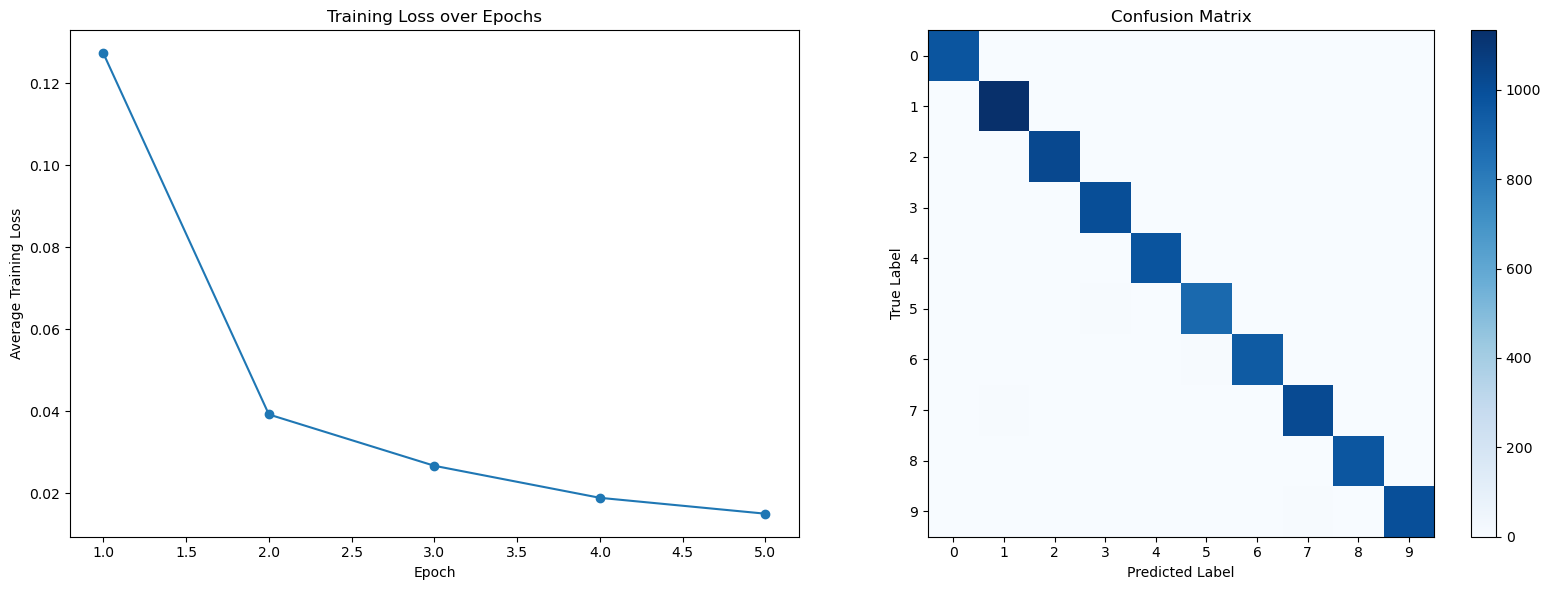

In [55]:
#최적화
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader as loader
import numpy as np
import optuna


def object(trial):
    lr=trial.suggest_loguniform('lr',1e-4, 1e-2)
    batch_size=trial.suggest_categorical("batch_size", [32, 64, 128])

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
        
    train_data=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
    test_data=datasets.MNIST(root='./data',train=False,download=True,transform=transform)

    train_loader=loader(train_data,batch_size=batch_size,shuffle=True)
    test_loader=loader(test_data, batch_size=1000,shuffle=True)

    model=simple_CNN()
    criter=nn.CrossEntropyLoss()
    #lr=0.001
    optimy=optim.Adam(model.parameters(),lr=lr)
    num_epoch=10
    train_mode(model,train_loader, criter,optimy,num_epoch=num_epoch)
    test_acc,_,_=eval_mode(model,test_loader)
    return test_acc

In [57]:
study = optuna.create_study(direction="maximize")
study.optimize(object, n_trials=20)

print("Best trial:")
best_trial = study.best_trial
print("  Accuracy: {:.2f}%".format(best_trial.value))
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2025-04-04 17:16:21,752] A new study created in memory with name: no-name-98c84a7d-6e90-46be-9d9a-78e28084accd
C:\Users\JH\AppData\Local\Temp\ipykernel_15848\2015550802.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr=trial.suggest_loguniform('lr',1e-4, 1e-2)


Epoch: 1/10, Train Loss: 0.2267
Epoch: 2/10, Train Loss: 0.0673
Epoch: 3/10, Train Loss: 0.0480
Epoch: 4/10, Train Loss: 0.0380
Epoch: 5/10, Train Loss: 0.0303
Epoch: 6/10, Train Loss: 0.0250
Epoch: 7/10, Train Loss: 0.0203
Epoch: 8/10, Train Loss: 0.0163
Epoch: 9/10, Train Loss: 0.0133
Epoch: 10/10, Train Loss: 0.0107


[I 2025-04-04 17:19:30,340] Trial 0 finished with value: 98.85 and parameters: {'lr': 0.00013934467875012285, 'batch_size': 32}. Best is trial 0 with value: 98.85.


Epoch: 1/10, Train Loss: 0.1042
Epoch: 2/10, Train Loss: 0.0414
Epoch: 3/10, Train Loss: 0.0280
Epoch: 4/10, Train Loss: 0.0226
Epoch: 5/10, Train Loss: 0.0165
Epoch: 6/10, Train Loss: 0.0155
Epoch: 7/10, Train Loss: 0.0137
Epoch: 8/10, Train Loss: 0.0108
Epoch: 9/10, Train Loss: 0.0101
Epoch: 10/10, Train Loss: 0.0109


[I 2025-04-04 17:23:02,720] Trial 1 finished with value: 99.08 and parameters: {'lr': 0.001992552229563033, 'batch_size': 32}. Best is trial 1 with value: 99.08.


Epoch: 1/10, Train Loss: 0.1999
Epoch: 2/10, Train Loss: 0.0523
Epoch: 3/10, Train Loss: 0.0365
Epoch: 4/10, Train Loss: 0.0273
Epoch: 5/10, Train Loss: 0.0223
Epoch: 6/10, Train Loss: 0.0161
Epoch: 7/10, Train Loss: 0.0114
Epoch: 8/10, Train Loss: 0.0106
Epoch: 9/10, Train Loss: 0.0097
Epoch: 10/10, Train Loss: 0.0079


[I 2025-04-04 17:24:46,138] Trial 2 finished with value: 98.99 and parameters: {'lr': 0.0007045827883077034, 'batch_size': 128}. Best is trial 1 with value: 99.08.


Epoch: 1/10, Train Loss: 0.3746
Epoch: 2/10, Train Loss: 0.0971
Epoch: 3/10, Train Loss: 0.0678
Epoch: 4/10, Train Loss: 0.0547
Epoch: 5/10, Train Loss: 0.0463
Epoch: 6/10, Train Loss: 0.0390
Epoch: 7/10, Train Loss: 0.0355
Epoch: 8/10, Train Loss: 0.0317
Epoch: 9/10, Train Loss: 0.0282
Epoch: 10/10, Train Loss: 0.0249


[I 2025-04-04 17:26:28,206] Trial 3 finished with value: 98.93 and parameters: {'lr': 0.00016975406583845436, 'batch_size': 128}. Best is trial 1 with value: 99.08.


Epoch: 1/10, Train Loss: 0.2896
Epoch: 2/10, Train Loss: 0.0788
Epoch: 3/10, Train Loss: 0.0552
Epoch: 4/10, Train Loss: 0.0437
Epoch: 5/10, Train Loss: 0.0367
Epoch: 6/10, Train Loss: 0.0299
Epoch: 7/10, Train Loss: 0.0251
Epoch: 8/10, Train Loss: 0.0220
Epoch: 9/10, Train Loss: 0.0176
Epoch: 10/10, Train Loss: 0.0153


[I 2025-04-04 17:28:50,842] Trial 4 finished with value: 98.95 and parameters: {'lr': 0.00016235207667767616, 'batch_size': 64}. Best is trial 1 with value: 99.08.


Epoch: 1/10, Train Loss: 0.2409
Epoch: 2/10, Train Loss: 0.0665
Epoch: 3/10, Train Loss: 0.0470
Epoch: 4/10, Train Loss: 0.0352
Epoch: 5/10, Train Loss: 0.0297
Epoch: 6/10, Train Loss: 0.0228
Epoch: 7/10, Train Loss: 0.0194
Epoch: 8/10, Train Loss: 0.0149
Epoch: 9/10, Train Loss: 0.0124
Epoch: 10/10, Train Loss: 0.0100


[I 2025-04-04 17:31:04,500] Trial 5 finished with value: 99.1 and parameters: {'lr': 0.00023389550702326948, 'batch_size': 64}. Best is trial 5 with value: 99.1.


Epoch: 1/10, Train Loss: 0.1132
Epoch: 2/10, Train Loss: 0.0529
Epoch: 3/10, Train Loss: 0.0442
Epoch: 4/10, Train Loss: 0.0350
Epoch: 5/10, Train Loss: 0.0317
Epoch: 6/10, Train Loss: 0.0266
Epoch: 7/10, Train Loss: 0.0294
Epoch: 8/10, Train Loss: 0.0231
Epoch: 9/10, Train Loss: 0.0253
Epoch: 10/10, Train Loss: 0.0272


[I 2025-04-04 17:34:59,213] Trial 6 finished with value: 98.71 and parameters: {'lr': 0.004131261842379601, 'batch_size': 32}. Best is trial 5 with value: 99.1.


Epoch: 1/10, Train Loss: 0.1130
Epoch: 2/10, Train Loss: 0.0403
Epoch: 3/10, Train Loss: 0.0270
Epoch: 4/10, Train Loss: 0.0198
Epoch: 5/10, Train Loss: 0.0173
Epoch: 6/10, Train Loss: 0.0129
Epoch: 7/10, Train Loss: 0.0113
Epoch: 8/10, Train Loss: 0.0099
Epoch: 9/10, Train Loss: 0.0096
Epoch: 10/10, Train Loss: 0.0070


[I 2025-04-04 17:38:30,857] Trial 7 finished with value: 99.12 and parameters: {'lr': 0.0013427671064174598, 'batch_size': 32}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.2679
Epoch: 2/10, Train Loss: 0.0664
Epoch: 3/10, Train Loss: 0.0485
Epoch: 4/10, Train Loss: 0.0379
Epoch: 5/10, Train Loss: 0.0301
Epoch: 6/10, Train Loss: 0.0265
Epoch: 7/10, Train Loss: 0.0209
Epoch: 8/10, Train Loss: 0.0175
Epoch: 9/10, Train Loss: 0.0140
Epoch: 10/10, Train Loss: 0.0120


[I 2025-04-04 17:40:13,512] Trial 8 finished with value: 98.94 and parameters: {'lr': 0.00034905605403235735, 'batch_size': 128}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.2011
Epoch: 2/10, Train Loss: 0.0589
Epoch: 3/10, Train Loss: 0.0426
Epoch: 4/10, Train Loss: 0.0317
Epoch: 5/10, Train Loss: 0.0252
Epoch: 6/10, Train Loss: 0.0191
Epoch: 7/10, Train Loss: 0.0156
Epoch: 8/10, Train Loss: 0.0117
Epoch: 9/10, Train Loss: 0.0093
Epoch: 10/10, Train Loss: 0.0083


[I 2025-04-04 17:43:27,252] Trial 9 finished with value: 99.09 and parameters: {'lr': 0.00018857577915017308, 'batch_size': 32}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.2117
Epoch: 2/10, Train Loss: 0.1316
Epoch: 3/10, Train Loss: 0.1201
Epoch: 4/10, Train Loss: 0.1187
Epoch: 5/10, Train Loss: 0.1139
Epoch: 6/10, Train Loss: 0.1089
Epoch: 7/10, Train Loss: 0.1087
Epoch: 8/10, Train Loss: 0.1050
Epoch: 9/10, Train Loss: 0.1029
Epoch: 10/10, Train Loss: 0.1048


[I 2025-04-04 17:47:36,948] Trial 10 finished with value: 97.06 and parameters: {'lr': 0.009837767330433931, 'batch_size': 32}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.1548
Epoch: 2/10, Train Loss: 0.0465
Epoch: 3/10, Train Loss: 0.0323
Epoch: 4/10, Train Loss: 0.0235
Epoch: 5/10, Train Loss: 0.0187
Epoch: 6/10, Train Loss: 0.0137
Epoch: 7/10, Train Loss: 0.0105
Epoch: 8/10, Train Loss: 0.0097
Epoch: 9/10, Train Loss: 0.0068
Epoch: 10/10, Train Loss: 0.0072


[I 2025-04-04 17:49:54,847] Trial 11 finished with value: 99.07 and parameters: {'lr': 0.0006950787479784885, 'batch_size': 64}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.1157
Epoch: 2/10, Train Loss: 0.0397
Epoch: 3/10, Train Loss: 0.0272
Epoch: 4/10, Train Loss: 0.0196
Epoch: 5/10, Train Loss: 0.0160
Epoch: 6/10, Train Loss: 0.0133
Epoch: 7/10, Train Loss: 0.0110
Epoch: 8/10, Train Loss: 0.0088
Epoch: 9/10, Train Loss: 0.0098
Epoch: 10/10, Train Loss: 0.0077


[I 2025-04-04 17:52:18,506] Trial 12 finished with value: 99.05 and parameters: {'lr': 0.0016281454158987305, 'batch_size': 64}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.1873
Epoch: 2/10, Train Loss: 0.0526
Epoch: 3/10, Train Loss: 0.0372
Epoch: 4/10, Train Loss: 0.0269
Epoch: 5/10, Train Loss: 0.0209
Epoch: 6/10, Train Loss: 0.0164
Epoch: 7/10, Train Loss: 0.0130
Epoch: 8/10, Train Loss: 0.0102
Epoch: 9/10, Train Loss: 0.0095
Epoch: 10/10, Train Loss: 0.0079


[I 2025-04-04 17:54:35,419] Trial 13 finished with value: 99.09 and parameters: {'lr': 0.00040064137840842745, 'batch_size': 64}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.1212
Epoch: 2/10, Train Loss: 0.0402
Epoch: 3/10, Train Loss: 0.0278
Epoch: 4/10, Train Loss: 0.0200
Epoch: 5/10, Train Loss: 0.0161
Epoch: 6/10, Train Loss: 0.0131
Epoch: 7/10, Train Loss: 0.0118
Epoch: 8/10, Train Loss: 0.0102
Epoch: 9/10, Train Loss: 0.0076
Epoch: 10/10, Train Loss: 0.0082


[I 2025-04-04 17:56:54,427] Trial 14 finished with value: 98.8 and parameters: {'lr': 0.0014308424355344124, 'batch_size': 64}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.1211
Epoch: 2/10, Train Loss: 0.0496
Epoch: 3/10, Train Loss: 0.0408
Epoch: 4/10, Train Loss: 0.0317
Epoch: 5/10, Train Loss: 0.0290
Epoch: 6/10, Train Loss: 0.0251
Epoch: 7/10, Train Loss: 0.0234
Epoch: 8/10, Train Loss: 0.0204
Epoch: 9/10, Train Loss: 0.0181
Epoch: 10/10, Train Loss: 0.0194


[I 2025-04-04 18:00:49,410] Trial 15 finished with value: 98.76 and parameters: {'lr': 0.003273587558772573, 'batch_size': 32}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.1678
Epoch: 2/10, Train Loss: 0.0505
Epoch: 3/10, Train Loss: 0.0351
Epoch: 4/10, Train Loss: 0.0261
Epoch: 5/10, Train Loss: 0.0189
Epoch: 6/10, Train Loss: 0.0161
Epoch: 7/10, Train Loss: 0.0119
Epoch: 8/10, Train Loss: 0.0097
Epoch: 9/10, Train Loss: 0.0085
Epoch: 10/10, Train Loss: 0.0074


[I 2025-04-04 18:03:02,528] Trial 16 finished with value: 99.05 and parameters: {'lr': 0.00043583133970032974, 'batch_size': 64}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.1386
Epoch: 2/10, Train Loss: 0.0405
Epoch: 3/10, Train Loss: 0.0281
Epoch: 4/10, Train Loss: 0.0201
Epoch: 5/10, Train Loss: 0.0152
Epoch: 6/10, Train Loss: 0.0143
Epoch: 7/10, Train Loss: 0.0088
Epoch: 8/10, Train Loss: 0.0078
Epoch: 9/10, Train Loss: 0.0082
Epoch: 10/10, Train Loss: 0.0062


[I 2025-04-04 18:05:19,419] Trial 17 finished with value: 99.03 and parameters: {'lr': 0.0009005231859208931, 'batch_size': 64}. Best is trial 7 with value: 99.12.


Epoch: 1/10, Train Loss: 0.1748
Epoch: 2/10, Train Loss: 0.0517
Epoch: 3/10, Train Loss: 0.0354
Epoch: 4/10, Train Loss: 0.0271
Epoch: 5/10, Train Loss: 0.0189
Epoch: 6/10, Train Loss: 0.0156
Epoch: 7/10, Train Loss: 0.0113
Epoch: 8/10, Train Loss: 0.0093
Epoch: 9/10, Train Loss: 0.0071
Epoch: 10/10, Train Loss: 0.0063


[I 2025-04-04 18:08:39,119] Trial 18 finished with value: 99.16 and parameters: {'lr': 0.00028132207739702827, 'batch_size': 32}. Best is trial 18 with value: 99.16.


Epoch: 1/10, Train Loss: 0.2622
Epoch: 2/10, Train Loss: 0.0764
Epoch: 3/10, Train Loss: 0.0544
Epoch: 4/10, Train Loss: 0.0431
Epoch: 5/10, Train Loss: 0.0355
Epoch: 6/10, Train Loss: 0.0293
Epoch: 7/10, Train Loss: 0.0243
Epoch: 8/10, Train Loss: 0.0202
Epoch: 9/10, Train Loss: 0.0169
Epoch: 10/10, Train Loss: 0.0146


[I 2025-04-04 18:11:41,979] Trial 19 finished with value: 98.96 and parameters: {'lr': 0.00010239727861452672, 'batch_size': 32}. Best is trial 18 with value: 99.16.


Best trial:
  Accuracy: 99.16%
  lr: 0.00028132207739702827
  batch_size: 32


In [58]:
#스케쥴러+최적화
def objective(trial):
        # 하이퍼파라미터 제안
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])


    step_size=trial.suggest_int('step_size',3,10)
    gamma=trial.suggest_float('gamma',0.1,0.9)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
        
    train_data=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
    test_data=datasets.MNIST(root='./data',train=False,download=True,transform=transform)

    train_loader=loader(train_data,batch_size=batch_size,shuffle=True)
    test_loader=loader(test_data, batch_size=1000,shuffle=True)

    model=simple_CNN()
    criter=nn.CrossEntropyLoss()
    #lr=0.001
    optimy=optim.Adam(model.parameters(),lr=lr)
    num_epoch=10

    scadule=optim.lr_scaduler.StepLR(optimy,step_size=step_size, gamma=gamma)
    train_mode(model,train_loader, criter,optimy,num_epoch=num_epoch)
    test_acc,_,_=eval_mode(model,test_loader)
    return test_acc

In [ ]:
def train_mode(model, train_loader, criter, optimy, num_epoch=5):
    model.train()
    train_history = []
    for epoch in range(num_epoch):
        total_loss = 0.0
        for data, target in train_loader:
            optimy.zero_grad()
            out = model(data)
            loss = criter(out, target)
            loss.backward()
            optimy.step()
            total_loss += loss.item()  # 각 배치의 손실을 누적합니다.
        scheduler.step()
        avg_loss = total_loss / len(train_loader)  # 에폭당 평균 손실 계산
        train_history.append(avg_loss)
        print(f"Epoch: {epoch+1}/{num_epoch}, Train Loss: {avg_loss:.4f}")
    return train_history


In [ ]:
def eval_mode(model, test_loader):
    model.eval()
    total=0.0
    correct=0.0
    all_pred=[]
    all_target=[]
    with torch.no_grad():
        for data,target in test_loader:
            out=model(data)
            pred=out.argmax(dim=1)
            all_pred.extend(pred.cpu().numpy())
            all_target.extend(target.cpu().numpy())
            correct+=pred.eq(target).sum().item()
            total+=data.size(0)
    accuracy=100.0*correct/total
    return accuracy, np.array(all_target), np.array(all_pred)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
best_trial = study.best_trial
print(f"  Accuracy: {best_trial.value:.2f}%")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")